In [1]:
import os,sys

try:
    import this_is_root
except:
    os.chdir(os.path.pardir) # change workdir to be root dir
    sys.path.insert(0, os.path.realpath("."))

import csv
import itertools
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import torch

from regions_of_interest_module.regions_of_interest import find_points_of_interest
from image_manipulation.crop_image_for_classifier import crop, is_valid_size
from image_loader.Image2numpy import convert_image_file_to_numpy
from image_manipulation.standardize_image import normalize_image

# now comes the neural network
from noise_reduction.model_denoise import DenoiseNet
from spot_classifier_NN.classifier_model import spots_classifier_net as ClassifierNet

import create_training_data.training_data_generator

from tqdm.notebook import tqdm_notebook as pbar

from regions_of_interest_module.get_regions_of_interest_from_net import get_default_denoise_net, get_regions_of_interest_generator_from_net

imgs_generator = create_training_data.training_data_generator.ClassifierValidationDataGenerator(num_channels=3)

IMAGE_NAME = 4
TAG = 3
BIG_COORDS = 2
SMALL_COORDS = 1
IMG = 0

np.random.seed(30)

  0%|          | 0/304 [00:00<?, ?it/s]

C:\Users\Lior\AppData\Local\Temp\ipykernel_5924\190586848.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axis = plt.subplots(3,NUM_COLUMNS,figsize=(14,6))


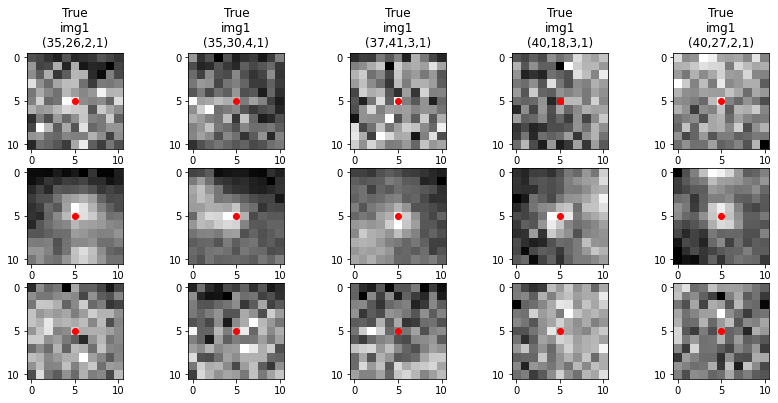

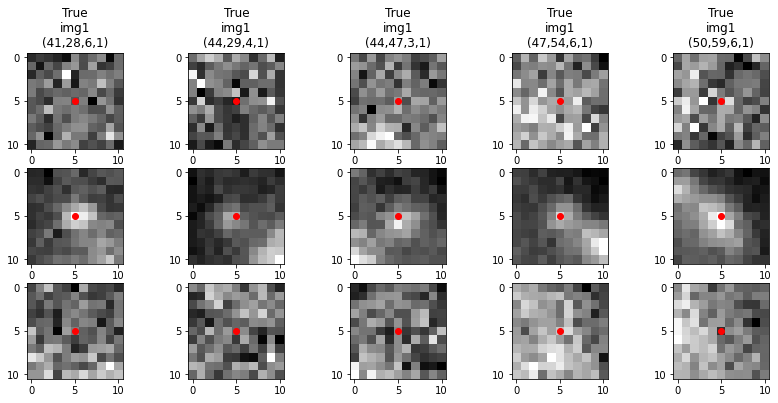

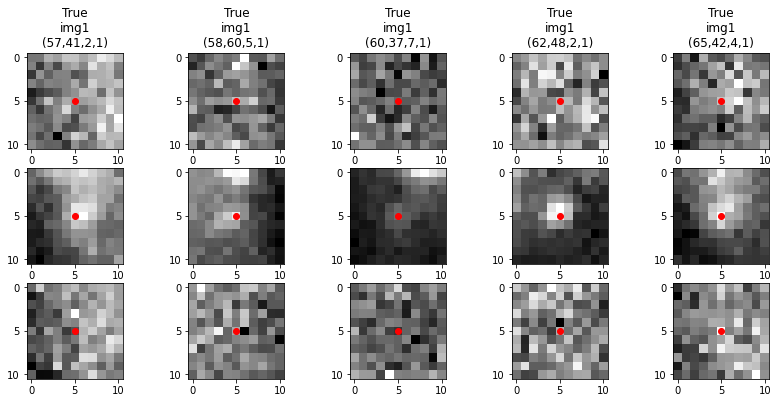

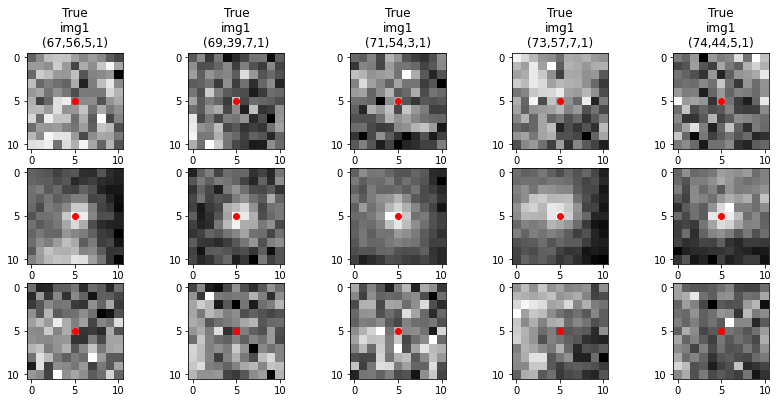

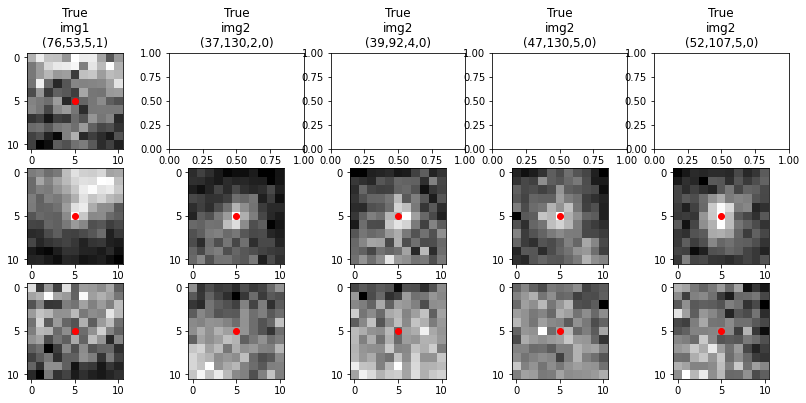

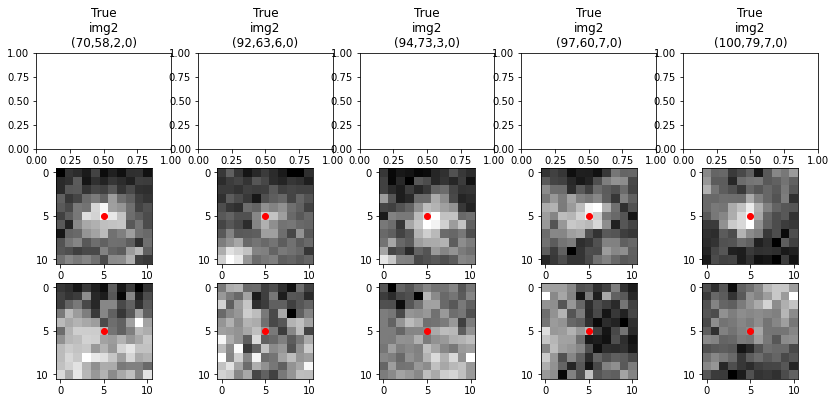

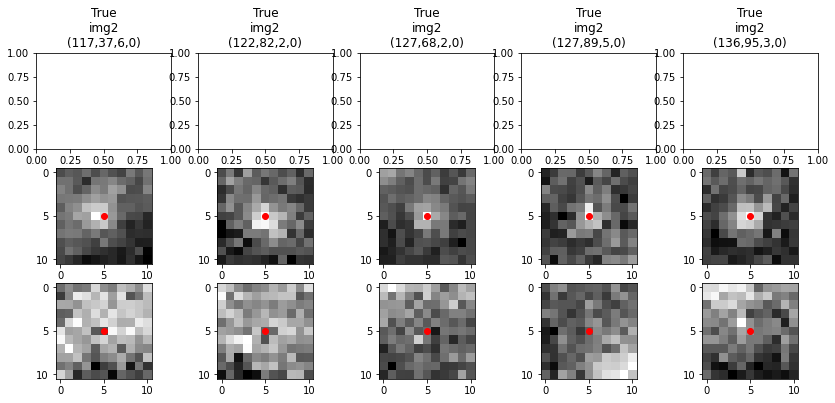

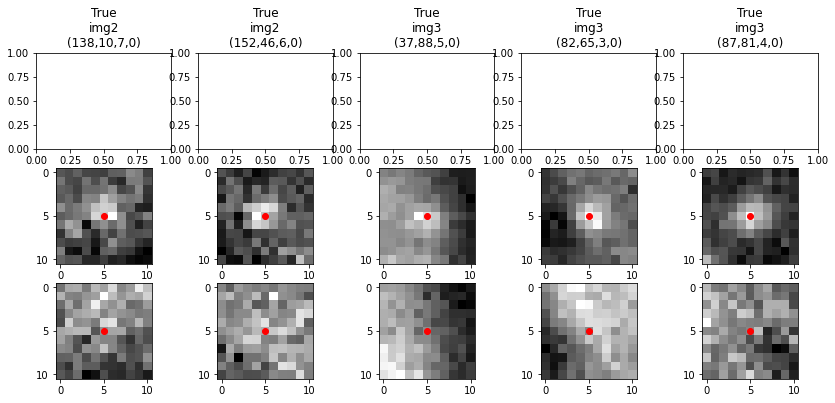

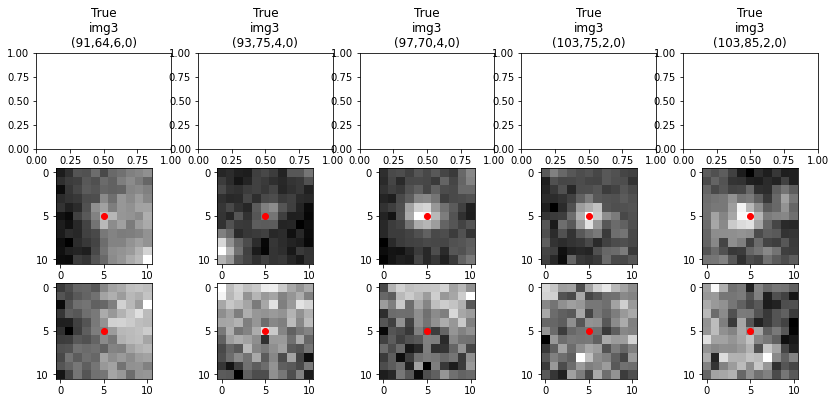

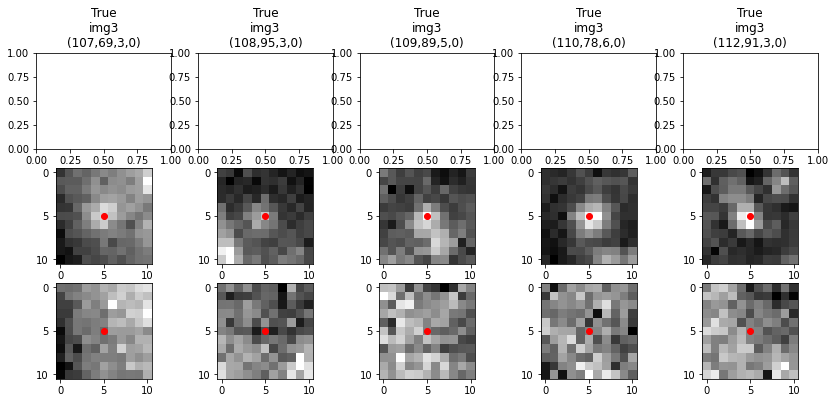

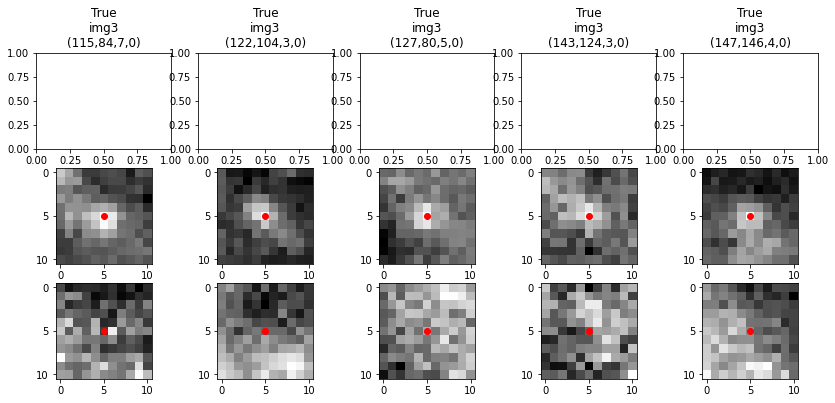

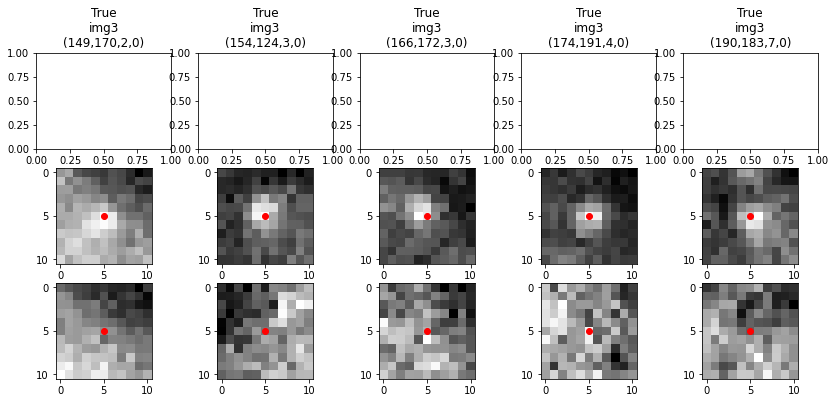

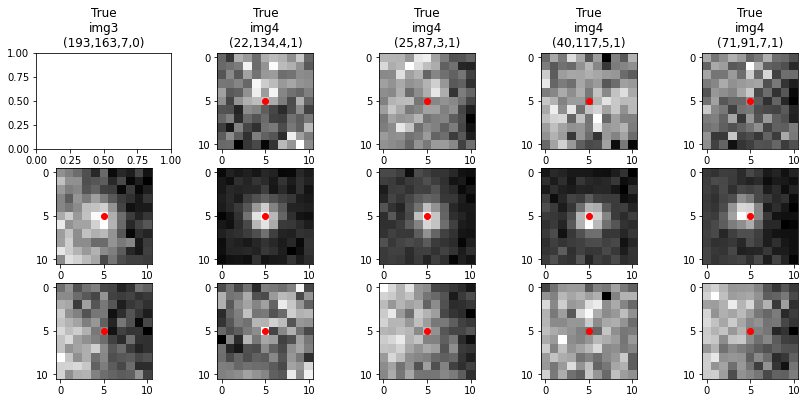

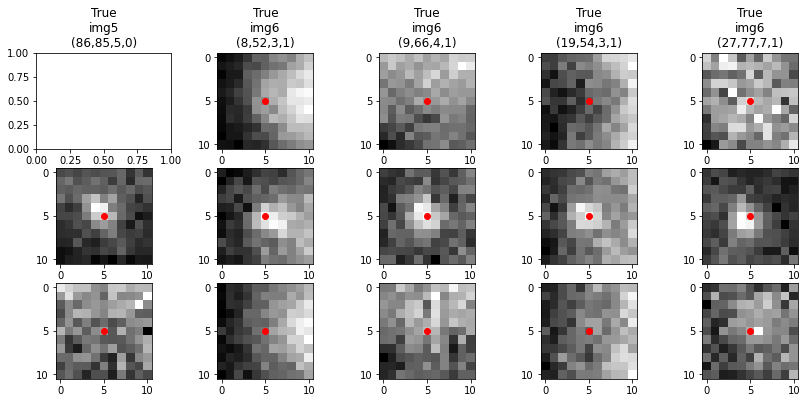

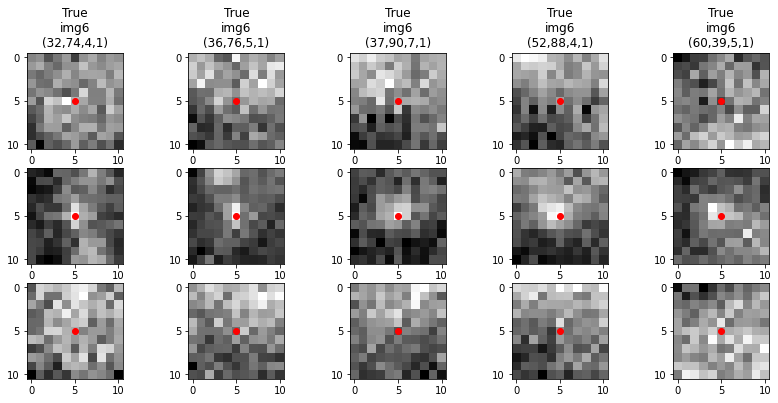

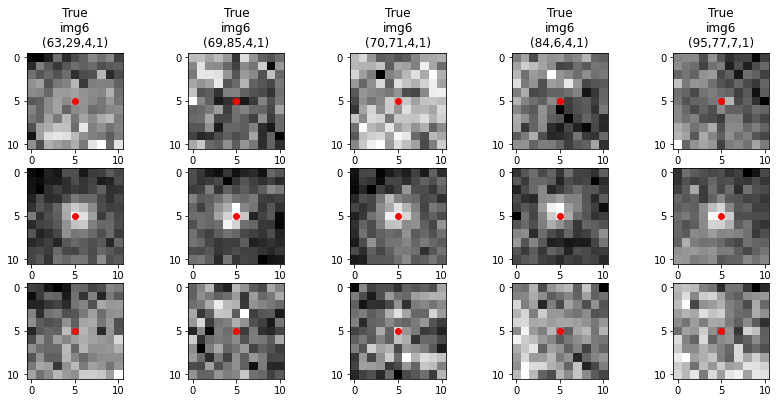

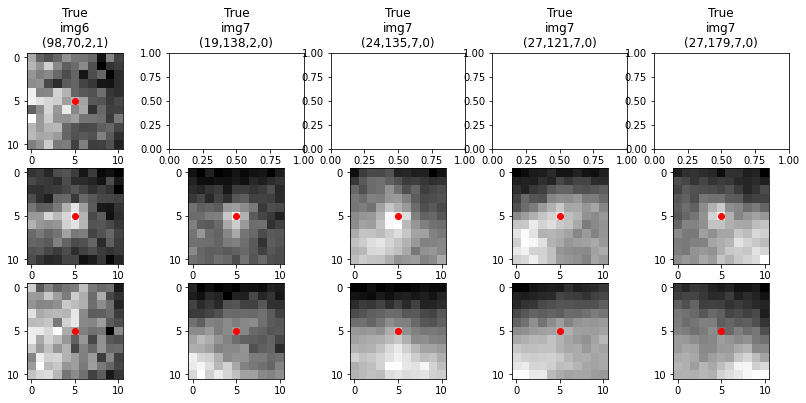

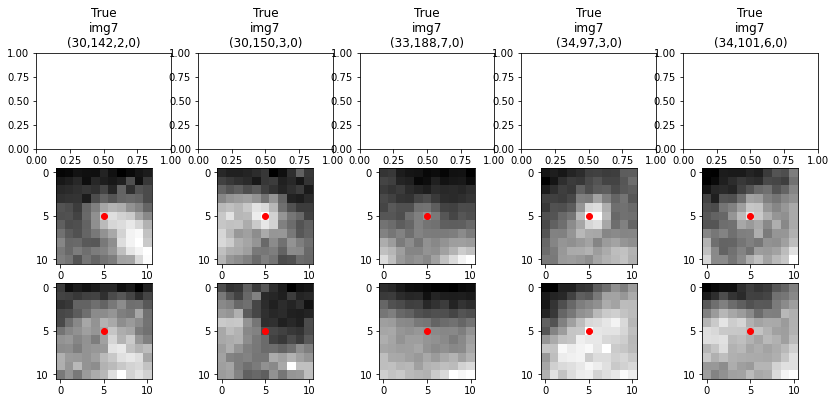

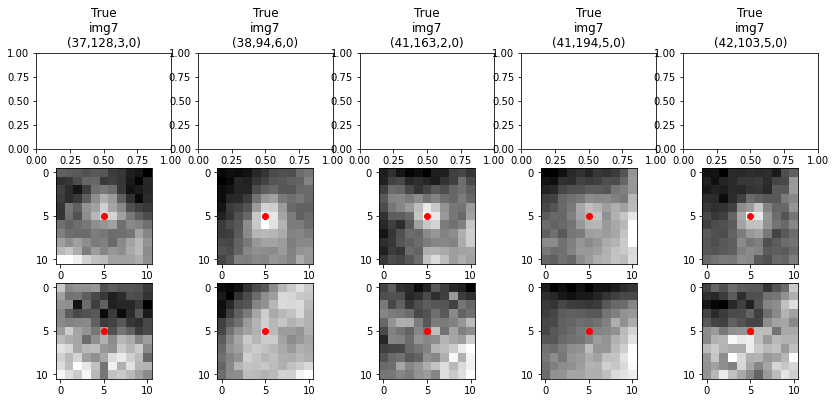

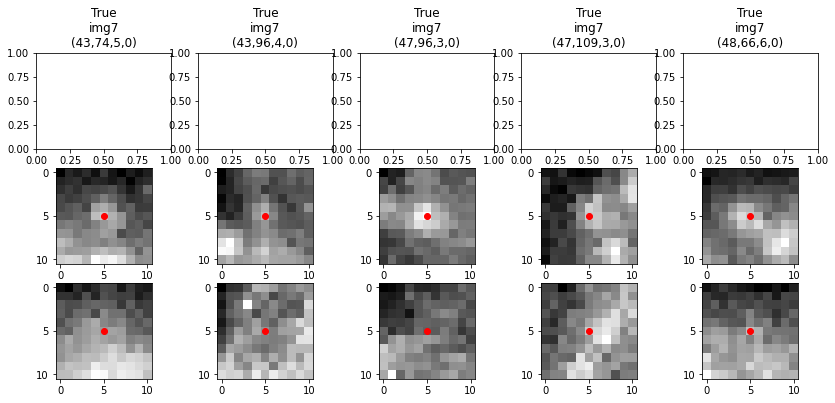

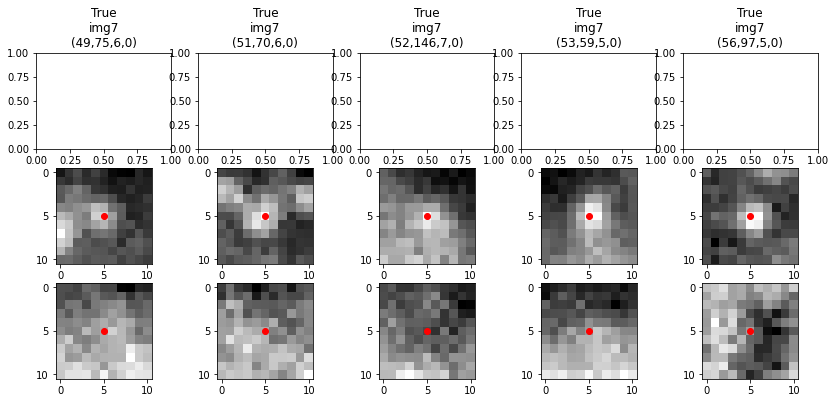

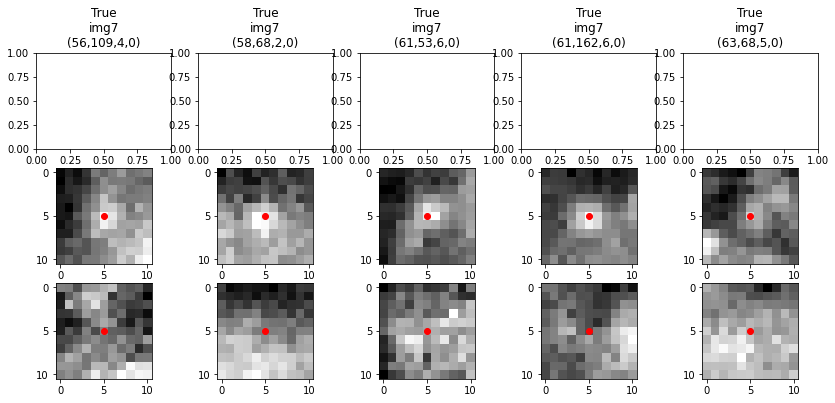

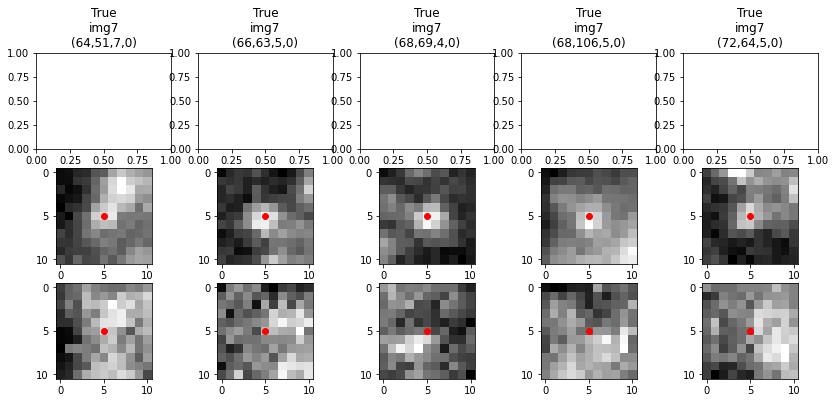

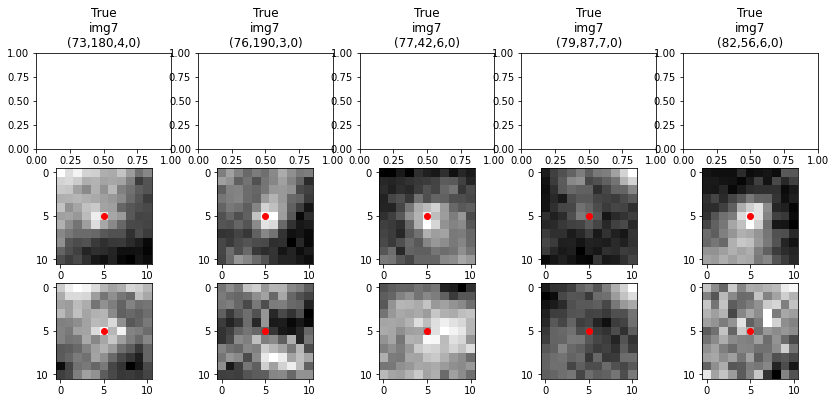

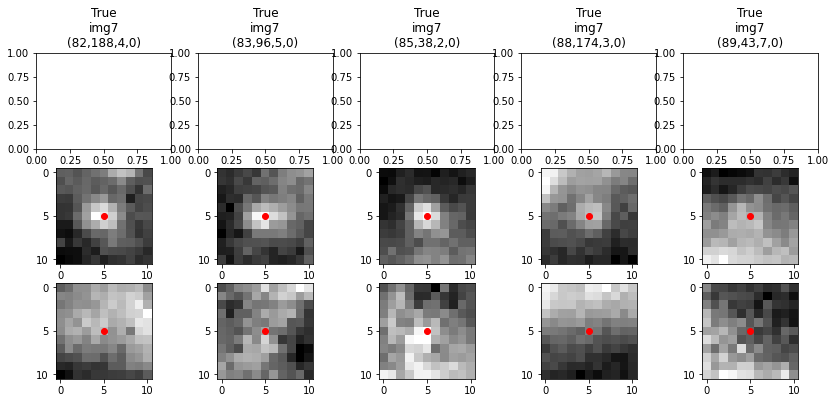

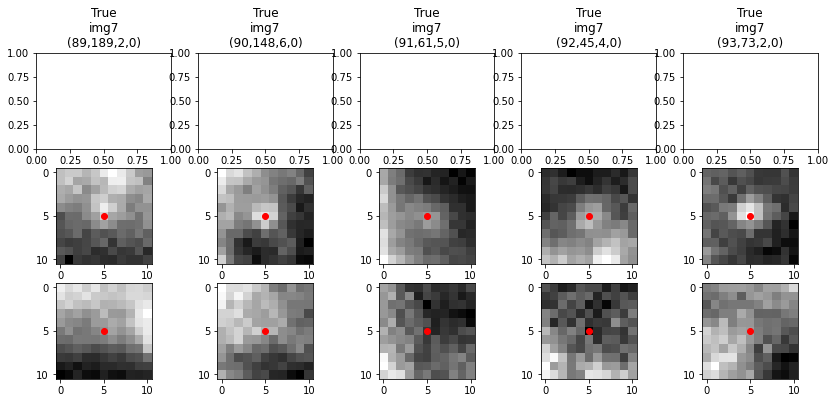

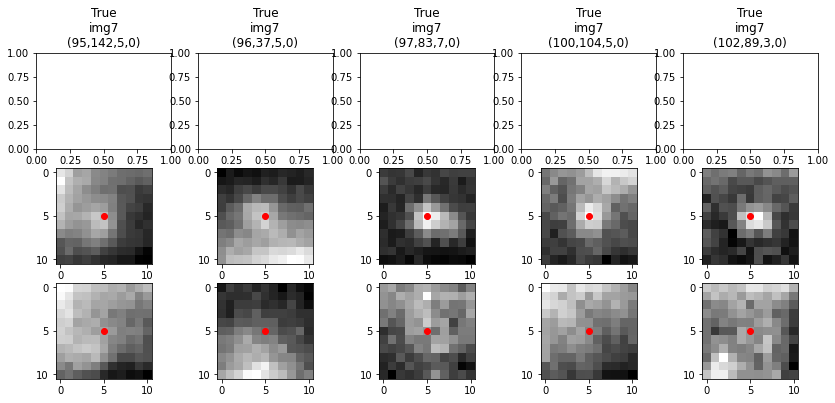

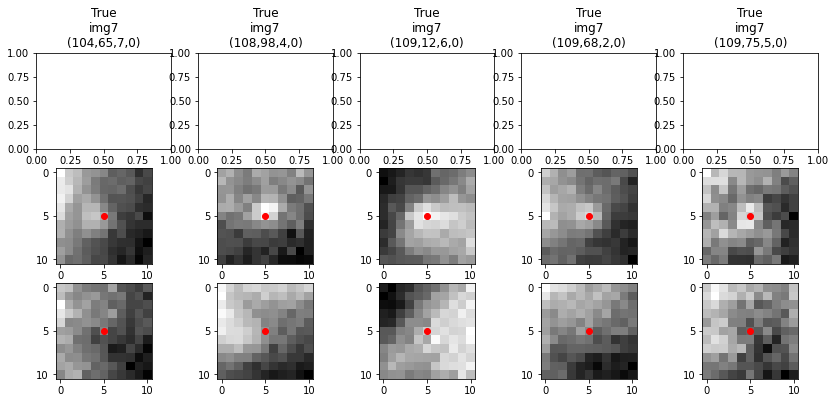

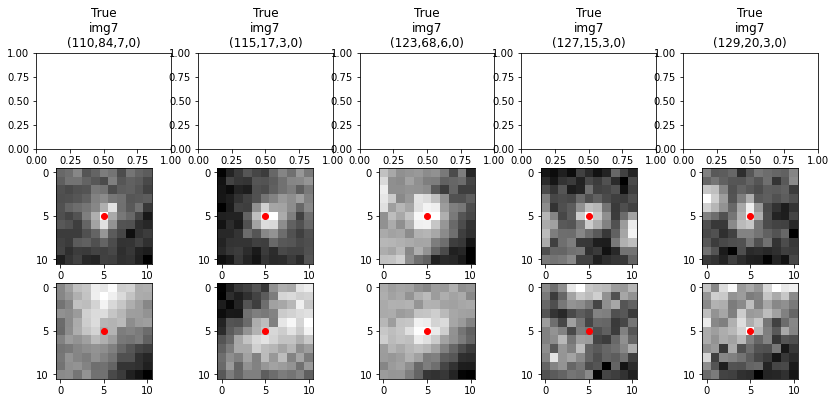

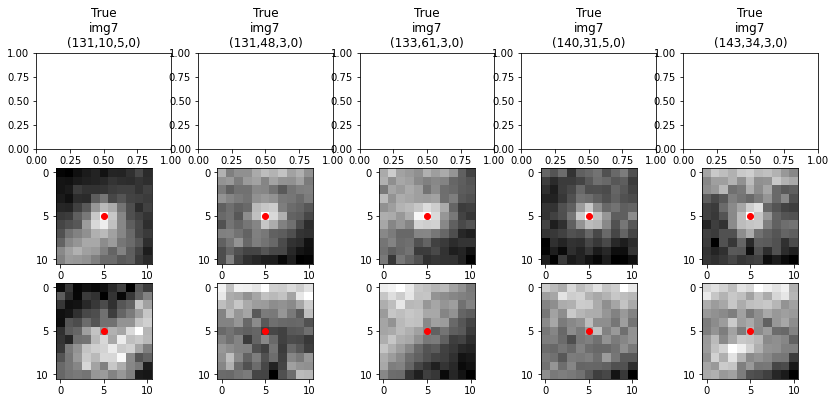

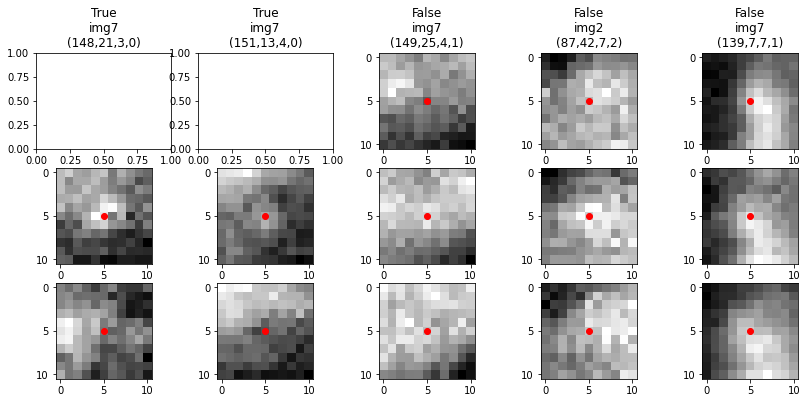

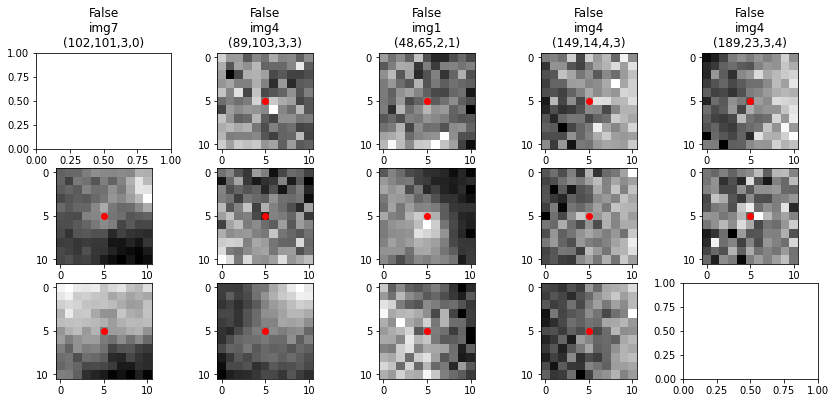

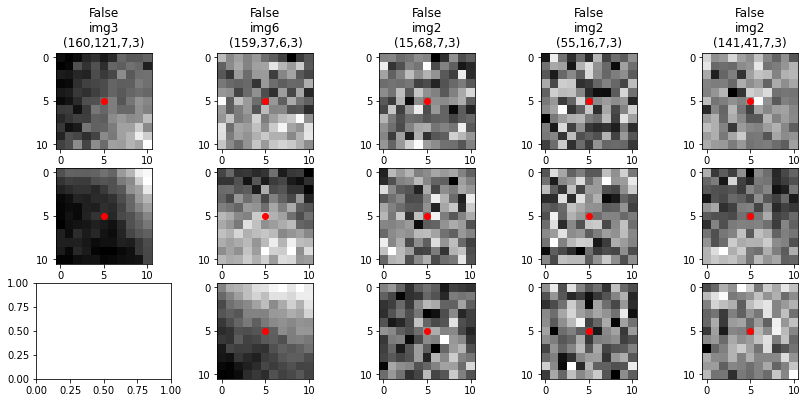

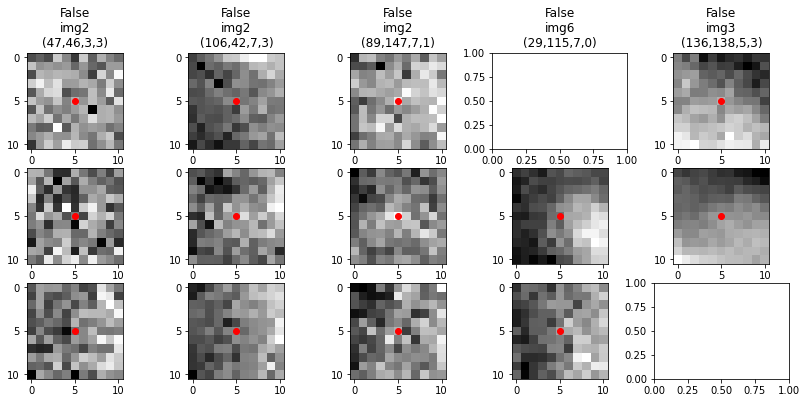

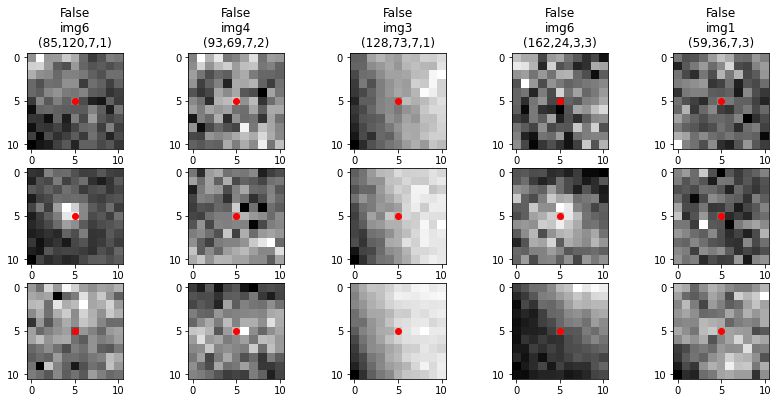

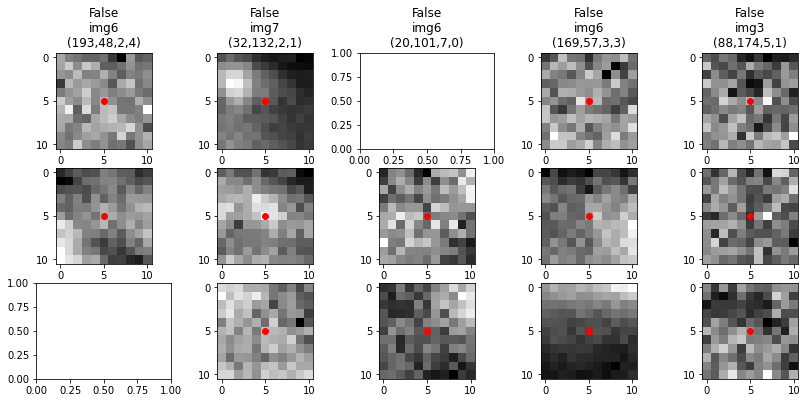

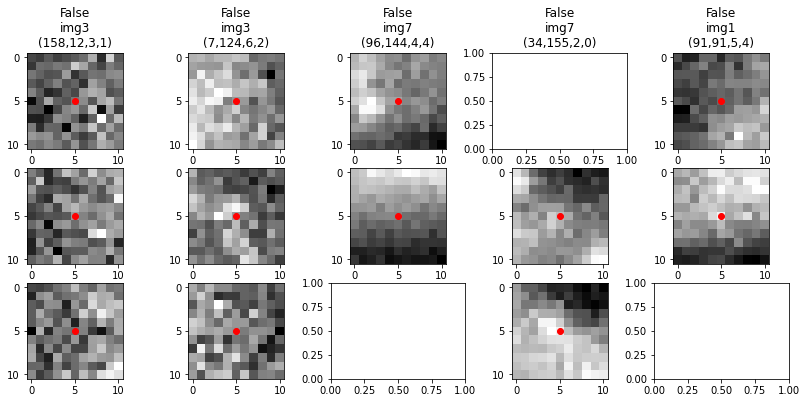

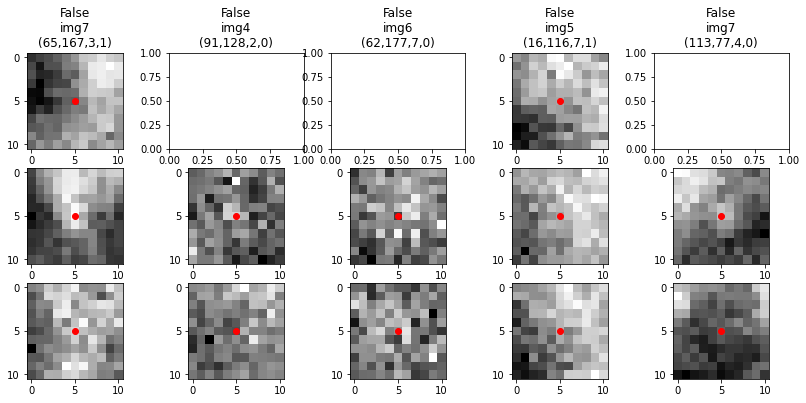

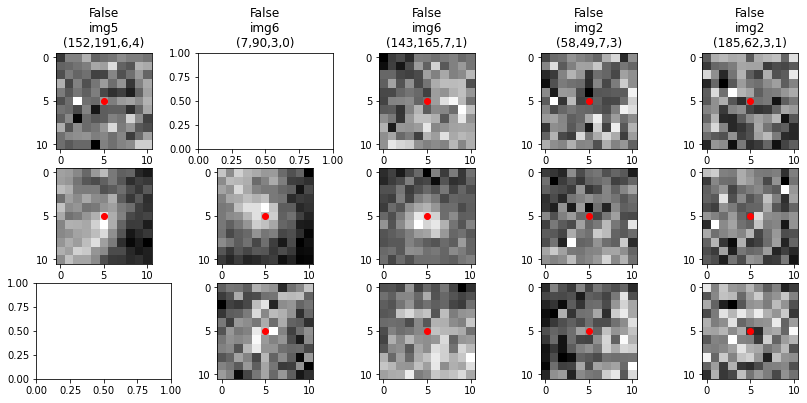

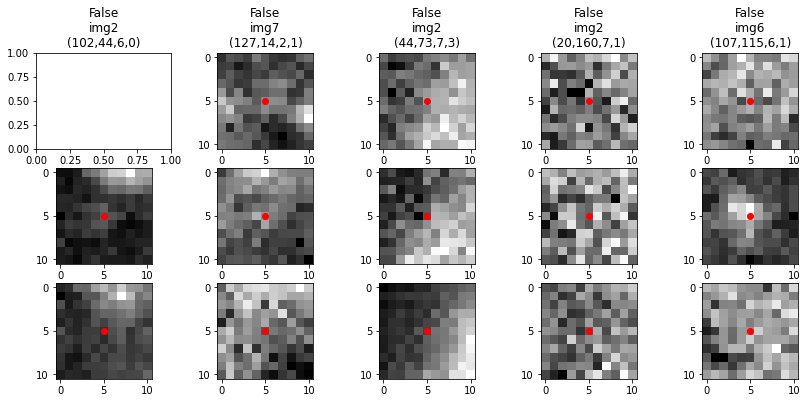

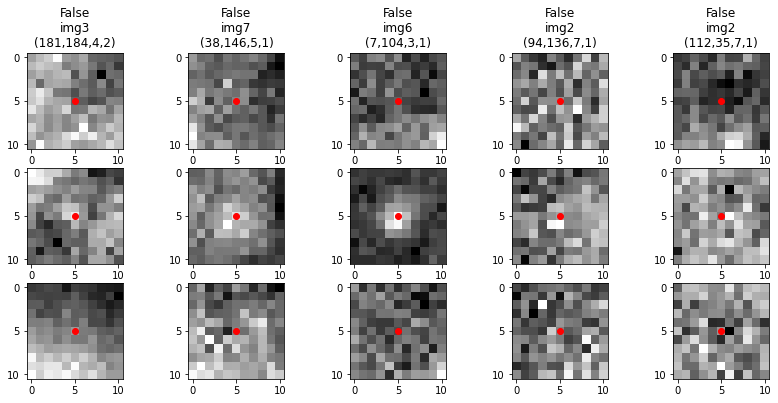

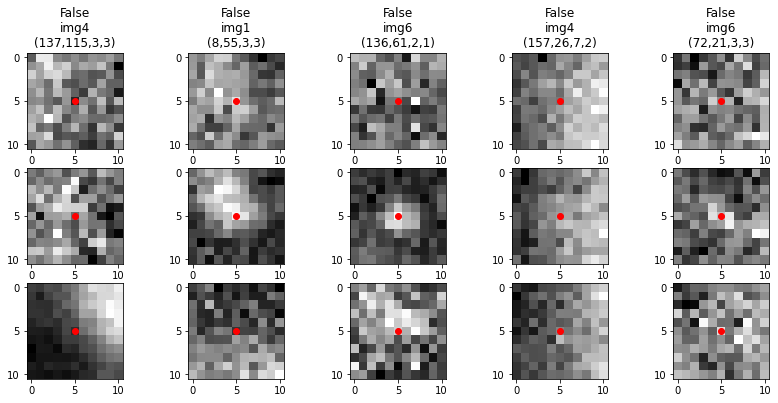

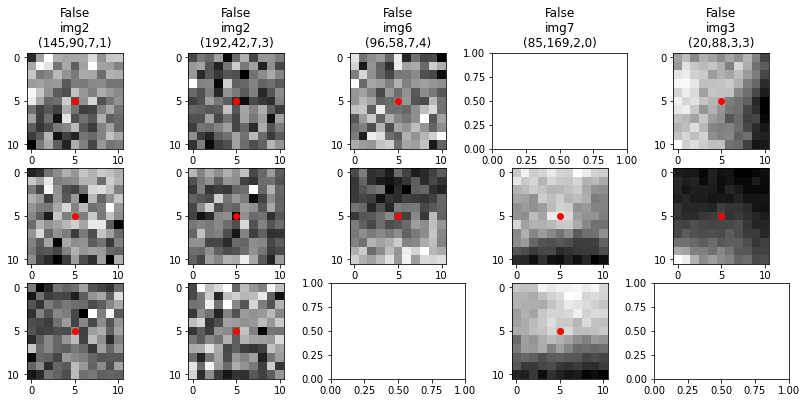

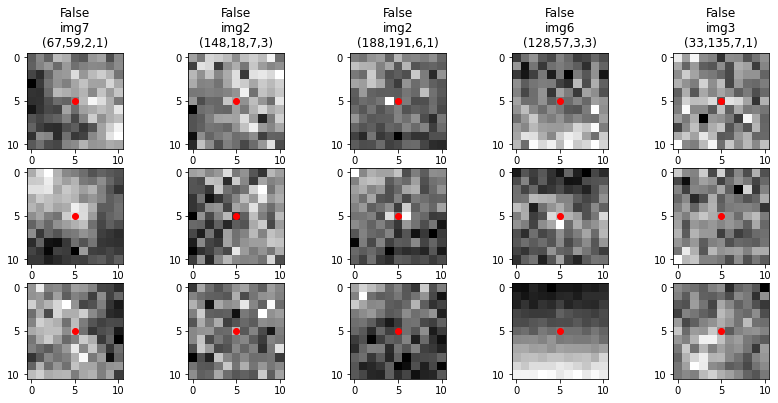

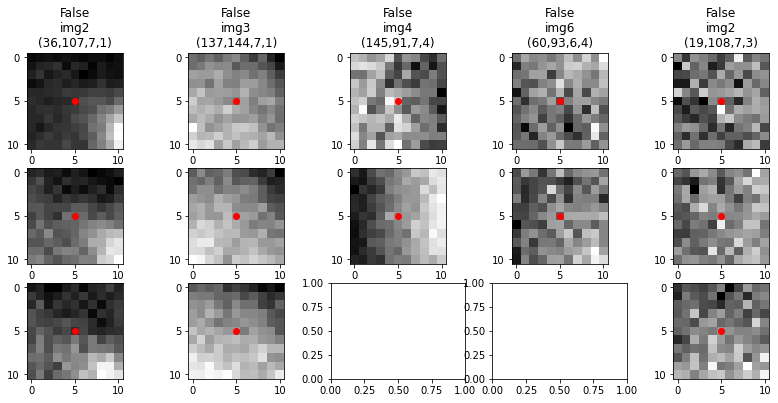

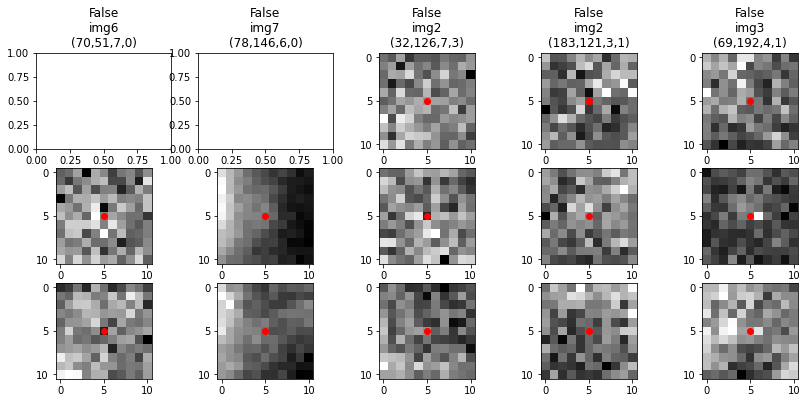

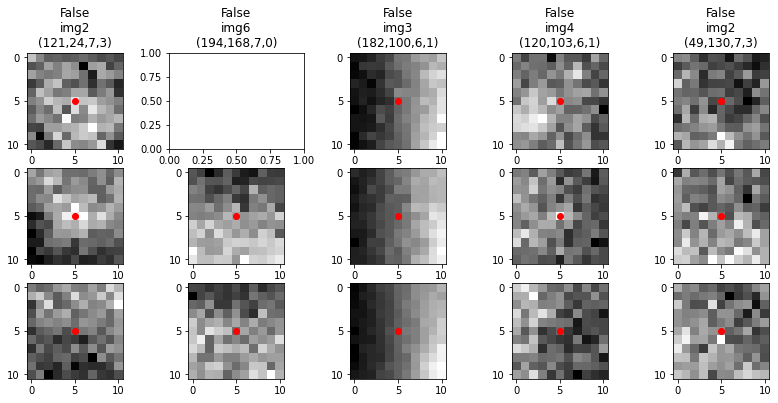

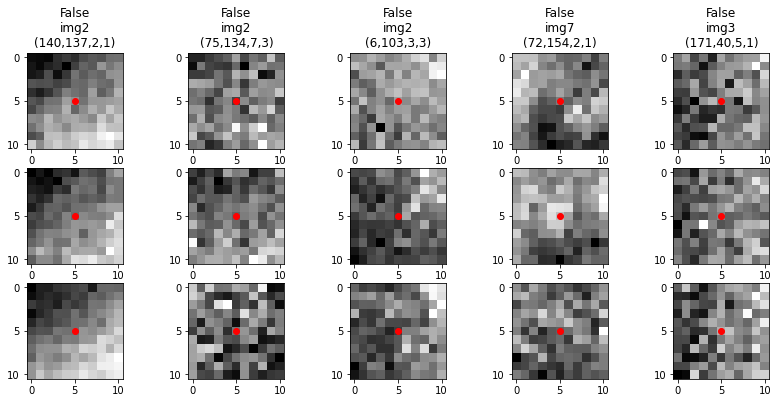

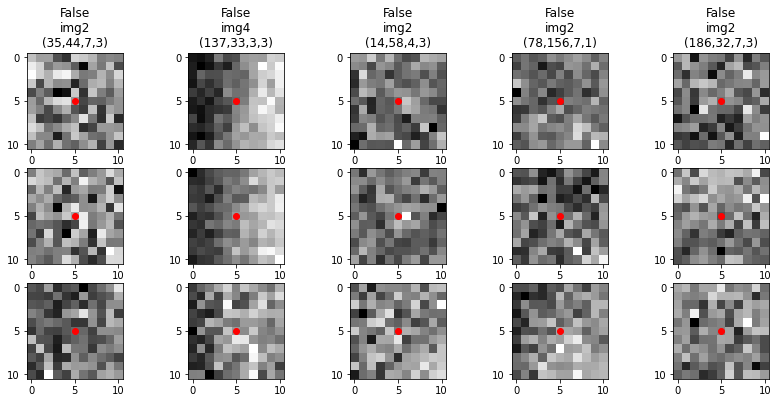

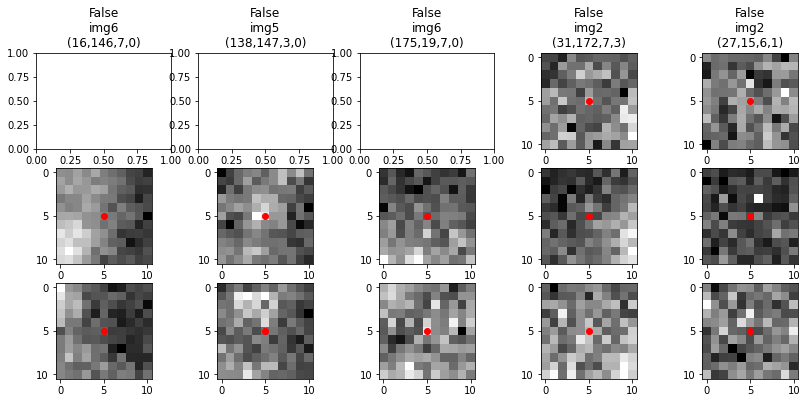

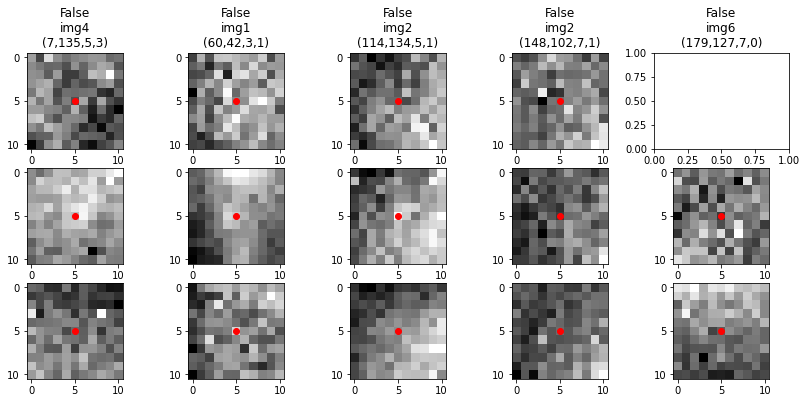

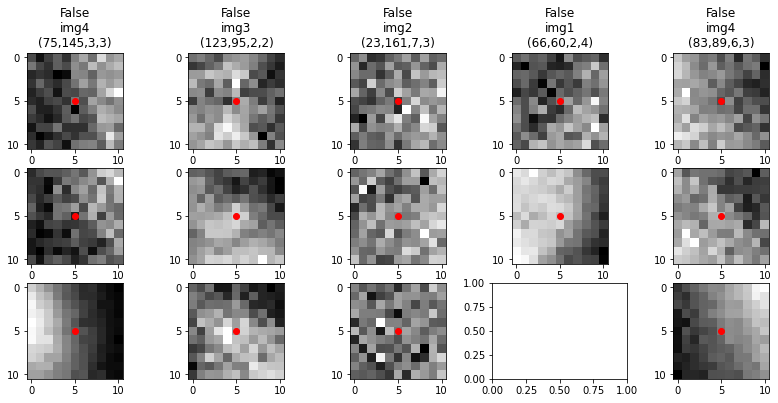

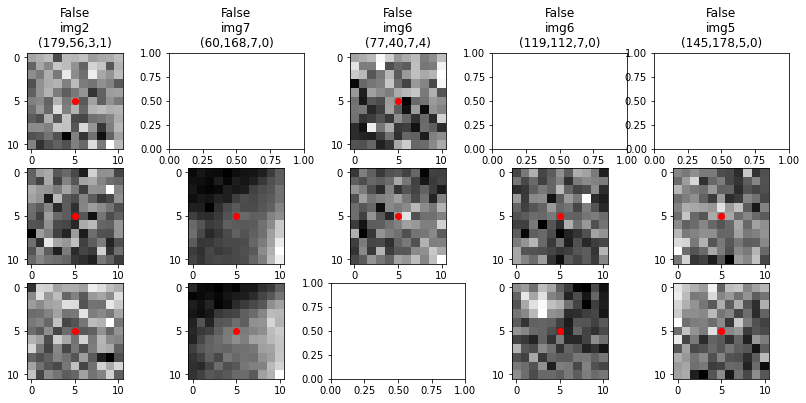

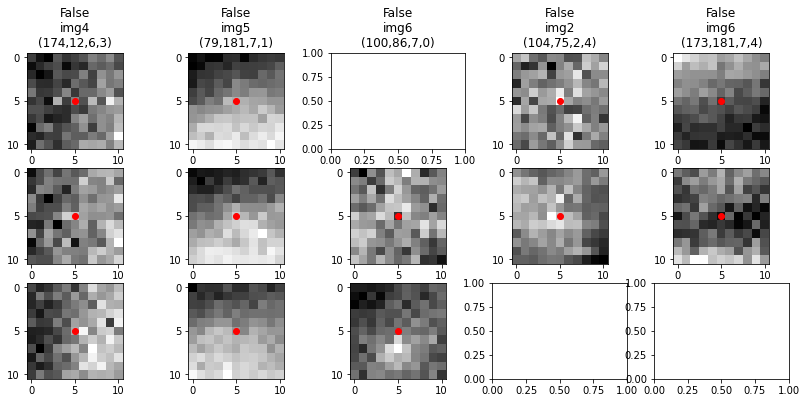

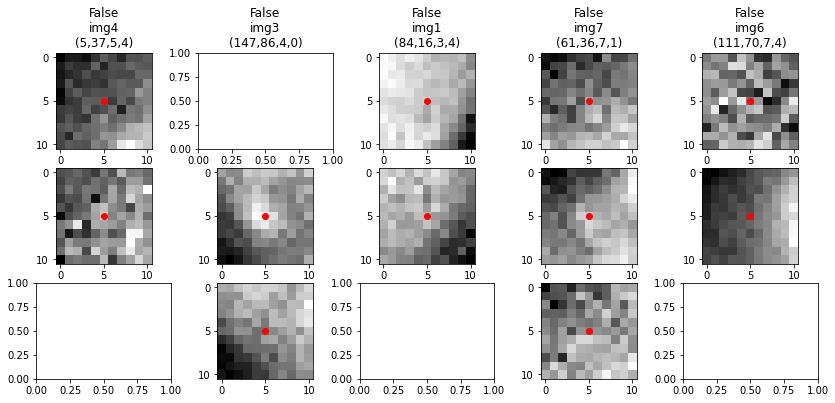

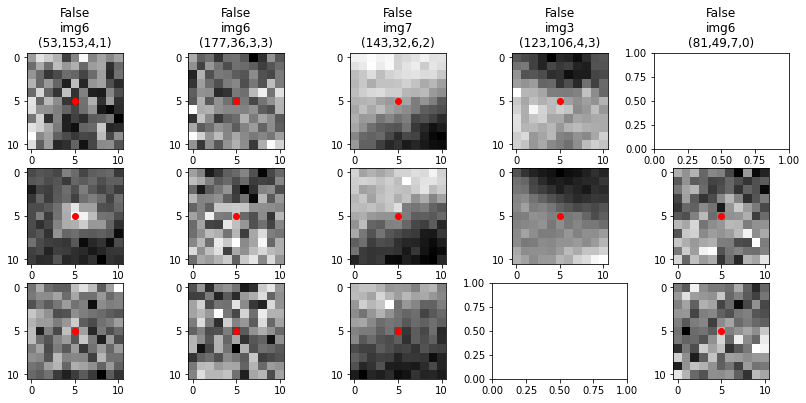

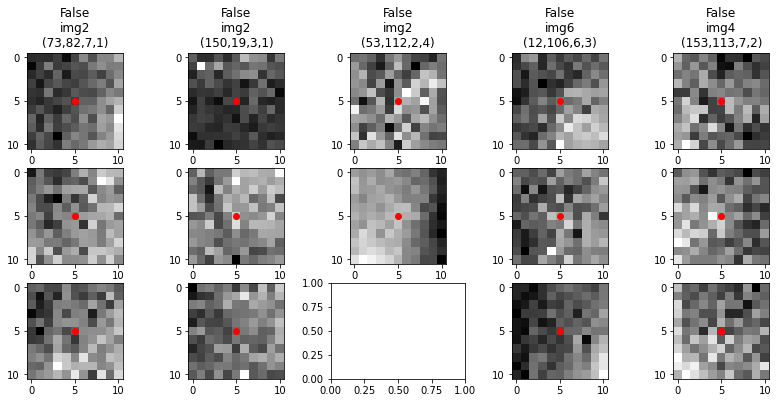

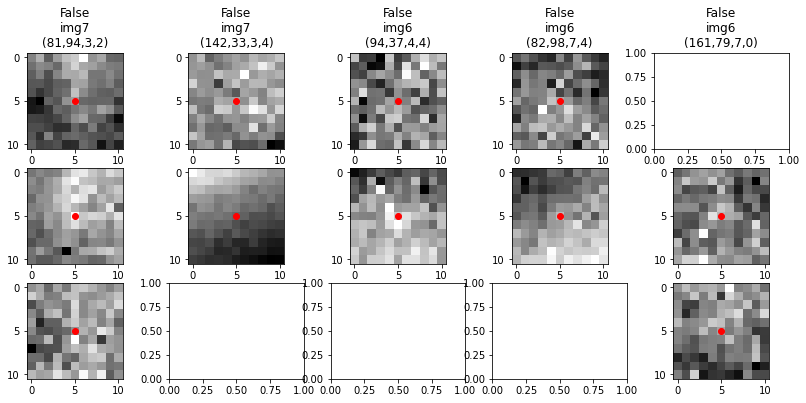

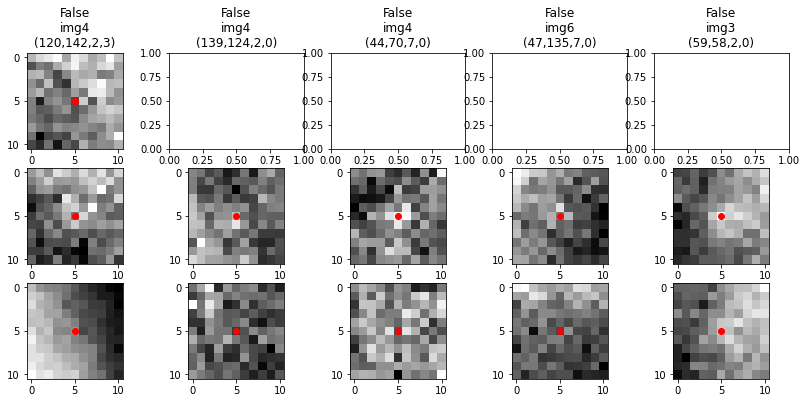

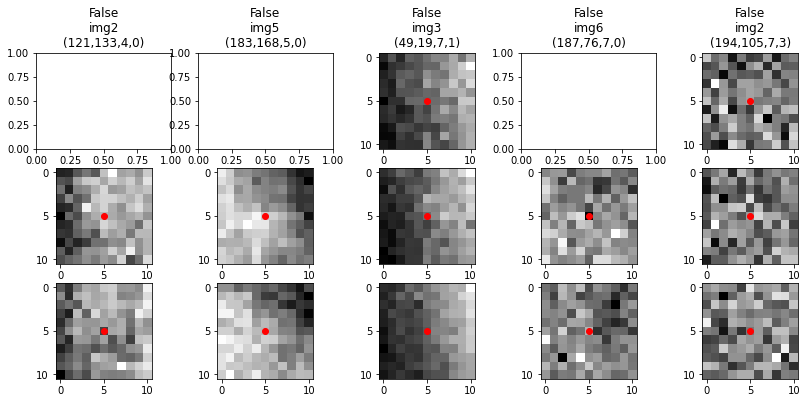

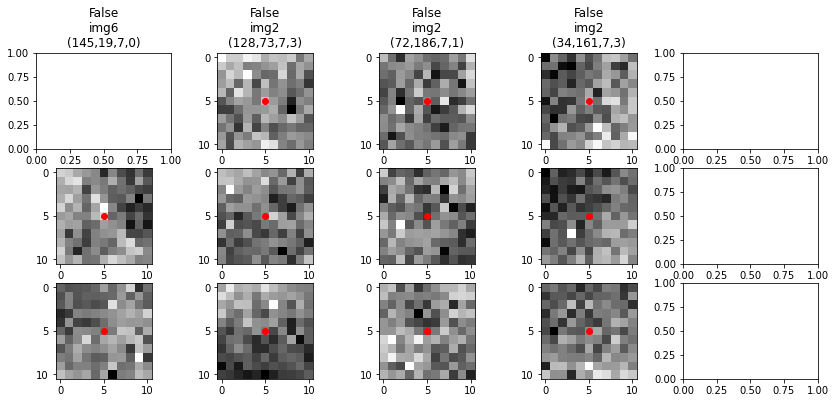

In [2]:
generated_data = imgs_generator.get_next_batch()
train_img, train_small_coordinates,train_big_coordinates, train_label = generated_data[IMG], generated_data[SMALL_COORDS],generated_data[BIG_COORDS], generated_data[TAG]
image_names = generated_data[IMAGE_NAME]

axes_iter = None
NUM_COLUMNS = 5
for i in pbar(range(len(train_label))):
    if i % NUM_COLUMNS == 0:
        fig,axis = plt.subplots(3,NUM_COLUMNS,figsize=(14,6))
        axes_iter = iter(list(axis.T.flatten()))
    ch = train_small_coordinates[i][-1]
    z = train_small_coordinates[i][-2]
    ax = next(axes_iter)
    ax.set_title(f"{train_label[i]}\n{image_names[i]}\n({train_big_coordinates[i][0]},{train_big_coordinates[i][1]},{train_big_coordinates[i][2]},{train_big_coordinates[i][3]})")
    if ch != 0:
        ax.imshow(train_img[i][...,z,ch - 1],cmap="gray")
        ax.plot(train_small_coordinates[i][1],train_small_coordinates[i][0],"or")
    ax = next(axes_iter)
    ax.imshow(train_img[i][...,z,ch],cmap="gray")
    ax.plot(train_small_coordinates[i][1],train_small_coordinates[i][0],"or")
    ax = next(axes_iter)
    try:
        ax.imshow(train_img[i][...,z,ch + 1],cmap="gray")
        ax.plot(train_small_coordinates[i][1],train_small_coordinates[i][0],"or")
    except:
        pass

In [5]:
image_names == "img2"

False

In [14]:
np.array(train_big_coordinates)[:,2]

array([2, 4, 3, 3, 2, 6, 4, 3, 6, 6, 2, 5, 7, 2, 4, 5, 7, 3, 7, 5, 5, 2,
       4, 5, 5, 2, 6, 3, 7, 7, 6, 2, 2, 5, 3, 7, 6, 5, 3, 4, 6, 4, 4, 2,
       2, 3, 3, 5, 6, 3, 7, 3, 5, 3, 4, 2, 3, 3, 4, 7, 7, 4, 3, 5, 7, 5,
       3, 4, 3, 7, 4, 5, 7, 4, 5, 4, 4, 4, 4, 7, 2, 2, 7, 7, 7, 2, 3, 7,
       3, 6, 3, 6, 2, 5, 5, 5, 4, 3, 3, 6, 6, 6, 7, 5, 5, 4, 2, 6, 6, 5,
       7, 5, 4, 5, 5, 4, 3, 6, 7, 6, 4, 5, 2, 3, 7, 2, 6, 5, 4, 2, 5, 5,
       7, 5, 3, 7, 4, 6, 2, 5, 7, 3, 6, 3, 3, 5, 3, 3, 5, 3, 3, 4, 4, 7,
       7, 3, 3, 2, 4, 3, 7, 6, 7, 7, 7, 3, 7, 7, 7, 5, 7, 7, 7, 3, 7, 2,
       2, 7, 3, 5, 3, 6, 4, 2, 5, 3, 2, 7, 7, 4, 6, 3, 7, 7, 3, 6, 2, 7,
       7, 6, 4, 5, 3, 7, 7, 3, 3, 2, 7, 3, 7, 7, 7, 2, 3, 2, 7, 6, 3, 7,
       7, 7, 7, 6, 7, 7, 6, 7, 3, 4, 7, 7, 6, 6, 7, 2, 7, 3, 2, 5, 7, 3,
       4, 7, 7, 7, 3, 7, 7, 6, 5, 3, 5, 7, 7, 3, 2, 7, 2, 6, 3, 7, 7, 7,
       5, 6, 7, 7, 2, 7, 5, 4, 3, 7, 7, 4, 3, 6, 4, 7, 7, 3, 2, 6, 7, 3,
       3, 4, 7, 7, 2, 2, 7, 7, 2, 4, 5, 7, 7, 7, 7,

In [9]:
idx = np.array(image_names) == "img2"
idx *= np.array(train_big_coordinates)[:,2] == 1
np.where(idx)

(array([], dtype=int64),)